In [1]:
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

from data import generate_segp_dataset, autocorrelation
from nn import Perceptron

torch.set_default_dtype(torch.float64)
plt.style.use('ggplot')

In [2]:
%load_ext autoreload
%autoreload 2

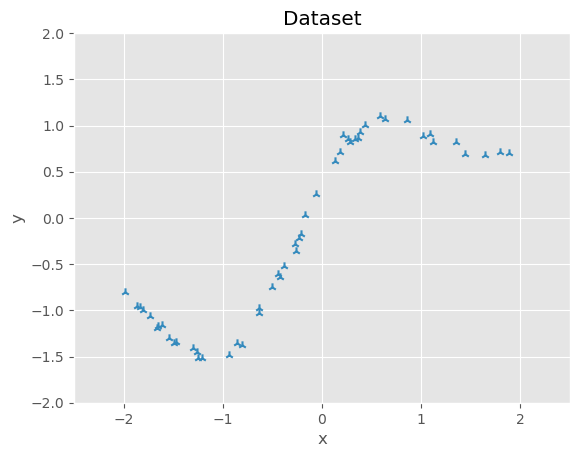

In [3]:
torch.manual_seed(3)
x, y = generate_segp_dataset(input_lower=-2.0, input_upper=2.0, num_points=50, noise_level=0.05, lengthscale=1.0)

plt.scatter(x, y, color='C1', marker='2')
plt.ylim([-2.0, 2.0])
plt.xlim([-2.5, 2.5])
plt.grid(True)
plt.title('Dataset')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

### Choose a suitable stepsize

In [4]:
net = Perceptron(3, nonlinearity='relu', prior='Gaussian', bias=True)

In [5]:
granularity = 21
stepsizes = torch.logspace(-6, -2, granularity)
alphas = torch.zeros((granularity,))
for i, stepsize in tqdm(enumerate(stepsizes)):
    _, alpha = net.langevin_monte_carlo(x, y, simulation_steps=1000, step_size=stepsize, pbar=False)
    alphas[i] = alpha

0it [00:00, ?it/s]

/home/troch/dev/simple_nn/nn.py:202: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  + torch.sqrt(torch.tensor(step_size)) * torch.randn_like(params)
21it [00:49,  2.36s/it]


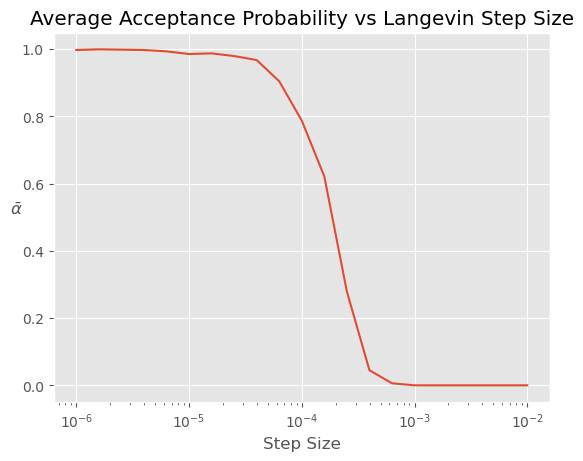

In [6]:
plt.plot(stepsizes, alphas)
plt.title('Average Acceptance Probability vs Langevin Step Size')
plt.xlabel('Step Size')
plt.ylabel(r'$\bar{\alpha}$', rotation=0)
plt.xscale('log')
plt.show()

### Evaluate convergence

In [42]:
net = Perceptron(3, nonlinearity='relu', prior='Gaussian', bias=True)
steps = 100000
posterior_samples, alpha = net.langevin_monte_carlo(x, y, simulation_steps=steps, step_size=2e-5)
print(alpha)

  0%|          | 0/100000 [00:00<?, ?it/s]

100%|██████████| 100000/100000 [04:20<00:00, 384.02it/s]

0.88486


In [43]:
log_potentials = torch.zeros((steps,))
for i, sample in tqdm(enumerate(posterior_samples)):
    with torch.no_grad():
        log_potentials[i] = net.get_log_potential(x, y, sample)

100000it [00:32, 3110.02it/s]


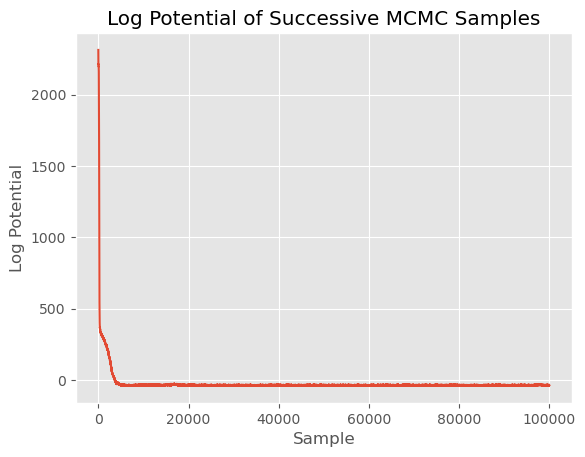

In [44]:
plt.plot(log_potentials)
plt.title('Log Potential of Successive MCMC Samples')
plt.xlabel('Sample')
plt.ylabel('Log Potential')
plt.show()

### Assess correlation between successive samples

In [45]:
burn_in = 20000
# burn_in = 0

In [46]:
max_lag = 10000
autocorrs = []
lags = [*range(max_lag)]
for lag in tqdm(lags):
    with torch.no_grad():
        autocorrs.append(autocorrelation(posterior_samples[burn_in:], lag=lag).mean())

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [01:33<00:00, 106.91it/s]


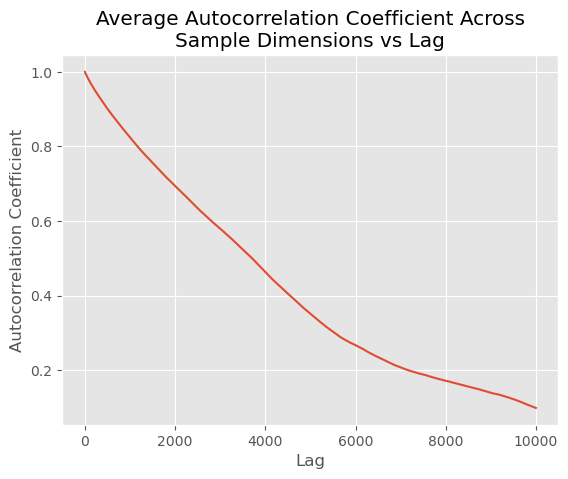

In [47]:
plt.plot(lags, autocorrs)
plt.title('Average Autocorrelation Coefficient Across\nSample Dimensions vs Lag')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation Coefficient')
plt.show()

In [60]:
thin = 1000 # really this should be set to around 8000
burn_in = 10000
useful_samples = posterior_samples[burn_in:][::thin]
print("Number of Useful Samples: ", useful_samples.shape[0])

Number of Useful Samples:  90


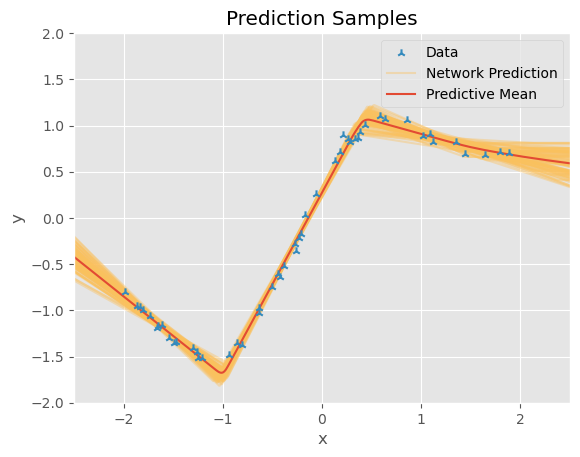

In [61]:
test_x = torch.linspace(-2.5, 2.5, 500)
pred_samps = torch.zeros((useful_samples.shape[0], 500))

plt.scatter(x, y, color='C1', marker='2', label='Data', zorder=1000)
for i, sample in enumerate(useful_samples):
    with torch.no_grad():
        net.sample_to_params(sample)
        preds = net(test_x)
        pred_samps[i,:] = preds.squeeze()
    if i == 0:
        label = 'Network Prediction'
    else:
        label = None
    plt.plot(test_x, preds, color='C4', label=label, alpha=0.4)
    
plt.plot(test_x, pred_samps.mean(dim=0), color='C0', label='Predictive Mean', alpha=1.0)
    
plt.ylim([-2.0, 2.0])
plt.xlim([-2.5, 2.5])
plt.grid(True)
plt.title('Prediction Samples')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()